# **Classical-ML-Classifiers-Analysis**


In [2]:
# ==========================================
# STEP 1 & 2: LOAD DATA, PREPROCESS, DEFINE MODELS
# ==========================================

import numpy as np
import pandas as pd
from sklearn.datasets import load_digits, load_breast_cancer, make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# --- 1. GET DATA (Automatically downloads/creates data) ---
print("⏳ Loading datasets...")

# Dataset A: High-Dimensional (Digits - 64 features)
digits = load_digits()
X_high = digits.data
y_high = digits.target

# Dataset B: Noisy (Breast Cancer + Artificial Noise)
data_low = load_breast_cancer()
X_low_clean = data_low.data
y_low = data_low.target
# Add random noise to make it harder (as requested by assignment)
np.random.seed(42)
noise = np.random.normal(0, 1, X_low_clean.shape)
X_low = X_low_clean + noise

# Dataset C: Non-Linear (Moons)
X_nl, y_nl = make_moons(n_samples=1000, noise=0.2, random_state=42)

# --- 2. PREPROCESSING (Split & Scale) ---
print("⚙️ Preprocessing (Splitting & Scaling)...")

# Helper function to split and scale
def preprocess_data(X, y):
    # Split 70% Train, 30% Test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    # Scale (Standardization)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, y_train, y_test

# Apply to all 3 datasets
X_train_high, X_test_high, y_train_high, y_test_high = preprocess_data(X_high, y_high)
X_train_low, X_test_low, y_train_low, y_test_low = preprocess_data(X_low, y_low)
X_train_nl, X_test_nl, y_train_nl, y_test_nl = preprocess_data(X_nl, y_nl)

# --- 3. DEFINE MODELS ---
print("📝 Defining Models & Hyperparameters...")

model_params = {
    'kNN': {
        'model': KNeighborsClassifier(),
        'params': {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}
    },
    'Linear_Classifier': { # SGD is an efficient linear classifier
        'model': SGDClassifier(random_state=42),
        'params': {'loss': ['hinge', 'perceptron'], 'alpha': [0.001, 0.01]}
    },
    'Logistic_Regression': {
        'model': LogisticRegression(max_iter=2000, random_state=42),
        'params': {'C': [0.1, 1, 10]}
    },
    'SVM': {
        'model': SVC(random_state=42),
        'params': [
            {'kernel': ['linear'], 'C': [1, 10]},
            {'kernel': ['rbf'], 'gamma': ['scale', 0.1], 'C': [1, 10]}
        ]
    },
    'Decision_Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {'max_depth': [5, 10, None], 'criterion': ['gini', 'entropy']}
    },
    'Naive_Bayes': {
        'model': GaussianNB(),
        'params': {'var_smoothing': [1e-9, 1e-8]}
    },
    'MLP': {
        'model': MLPClassifier(max_iter=1000, random_state=42),
        'params': {'hidden_layer_sizes': [(50,), (100,)], 'activation': ['relu', 'tanh']}
    }
}

print("✅ SUCCESS! Data loaded and Models defined.")
print(f"High-Dim Data Shape: {X_train_high.shape}")
print(f"Noisy Data Shape: {X_train_low.shape}")
print(f"Non-Linear Data Shape: {X_train_nl.shape}")


⏳ Loading datasets...
⚙️ Preprocessing (Splitting & Scaling)...
📝 Defining Models & Hyperparameters...
✅ SUCCESS! Data loaded and Models defined.
High-Dim Data Shape: (1257, 64)
Noisy Data Shape: (398, 30)
Non-Linear Data Shape: (700, 2)


In [3]:
import time
import pandas as pd
from sklearn.model_selection import GridSearchCV

# 1. Organize datasets into a list for looping
datasets_list = [
    ("High-Dimensional", X_train_high, y_train_high, X_test_high, y_test_high),
    ("Noisy", X_train_low, y_train_low, X_test_low, y_test_low),
    ("Non-Linear", X_train_nl, y_train_nl, X_test_nl, y_test_nl)
]

# List to store all results
results_data = []

print("🚀 Starting Experiments... (This may take a few minutes)\n")

# 2. Loop through each Dataset
for ds_name, X_tr, y_tr, X_te, y_te in datasets_list:
    print(f"--- 📂 Dataset: {ds_name} ---")

    # 3. Loop through each Model
    for model_name, config in model_params.items():
        print(f"   Training {model_name}...", end=" ")

        # Measure Training Time
        start_time = time.time()

        # GridSearchCV: Finds best params using 5-fold Cross-Validation
        grid = GridSearchCV(config['model'], config['params'], cv=5, n_jobs=-1, scoring='accuracy')
        grid.fit(X_tr, y_tr)

        end_time = time.time()
        duration = end_time - start_time

        # Get Best Model & Evaluate
        best_model = grid.best_estimator_
        train_acc = best_model.score(X_tr, y_tr)
        test_acc = best_model.score(X_te, y_te)

        print(f"✅ Done. (Test Acc: {test_acc:.3f})")

        # Save results
        results_data.append({
            'Dataset': ds_name,
            'Model': model_name,
            'Best_Params': str(grid.best_params_),
            'Train_Acc': train_acc,
            'Test_Acc': test_acc,
            'Time_Sec': duration,
            'Estimator': best_model # Saving the actual model for plotting later
        })

# 4. Convert results to a DataFrame for nice display
results_df = pd.DataFrame(results_data)

print("\n🎉 All Experiments Completed Successfully!")

# Show a summary table
display_cols = ['Dataset', 'Model', 'Train_Acc', 'Test_Acc', 'Time_Sec']
results_df[display_cols].sort_values(by=['Dataset', 'Test_Acc'], ascending=[True, False])


🚀 Starting Experiments... (This may take a few minutes)

--- 📂 Dataset: High-Dimensional ---
   Training kNN... ✅ Done. (Test Acc: 0.974)
   Training Linear_Classifier... ✅ Done. (Test Acc: 0.954)
   Training Logistic_Regression... ✅ Done. (Test Acc: 0.981)
   Training SVM... ✅ Done. (Test Acc: 0.983)
   Training Decision_Tree... ✅ Done. (Test Acc: 0.822)
   Training Naive_Bayes... ✅ Done. (Test Acc: 0.787)
   Training MLP... ✅ Done. (Test Acc: 0.980)
--- 📂 Dataset: Noisy ---
   Training kNN... ✅ Done. (Test Acc: 0.918)
   Training Linear_Classifier... ✅ Done. (Test Acc: 0.930)
   Training Logistic_Regression... ✅ Done. (Test Acc: 0.936)
   Training SVM... ✅ Done. (Test Acc: 0.953)
   Training Decision_Tree... ✅ Done. (Test Acc: 0.912)
   Training Naive_Bayes... ✅ Done. (Test Acc: 0.918)
   Training MLP... ✅ Done. (Test Acc: 0.918)
--- 📂 Dataset: Non-Linear ---
   Training kNN... ✅ Done. (Test Acc: 0.983)
   Training Linear_Classifier... ✅ Done. (Test Acc: 0.870)
   Training Logistic_R

,Dataset,Model,Train_Acc,Test_Acc,Time_Sec
3,High-Dimensional,SVM,0.997613,0.983333,3.425547
2,High-Dimensional,Logistic_Regression,1.000000,0.981481,1.224812
6,High-Dimensional,MLP,1.000000,0.979630,28.692646
0,High-Dimensional,kNN,1.000000,0.974074,7.018019
1,High-Dimensional,Linear_Classifier,0.984089,0.953704,1.856148
4,High-Dimensional,Decision_Tree,1.000000,0.822222,0.869688
5,High-Dimensional,Naive_Bayes,0.812251,0.787037,0.162984
10,Noisy,SVM,0.954774,0.953216,0.338107
9,Noisy,Logistic_Regression,0.942211,0.935673,0.079549
8,Noisy,Linear_Classifier,0.952261,0.929825,0.066363


📊 Generating Decision Boundaries for Non-Linear Data...


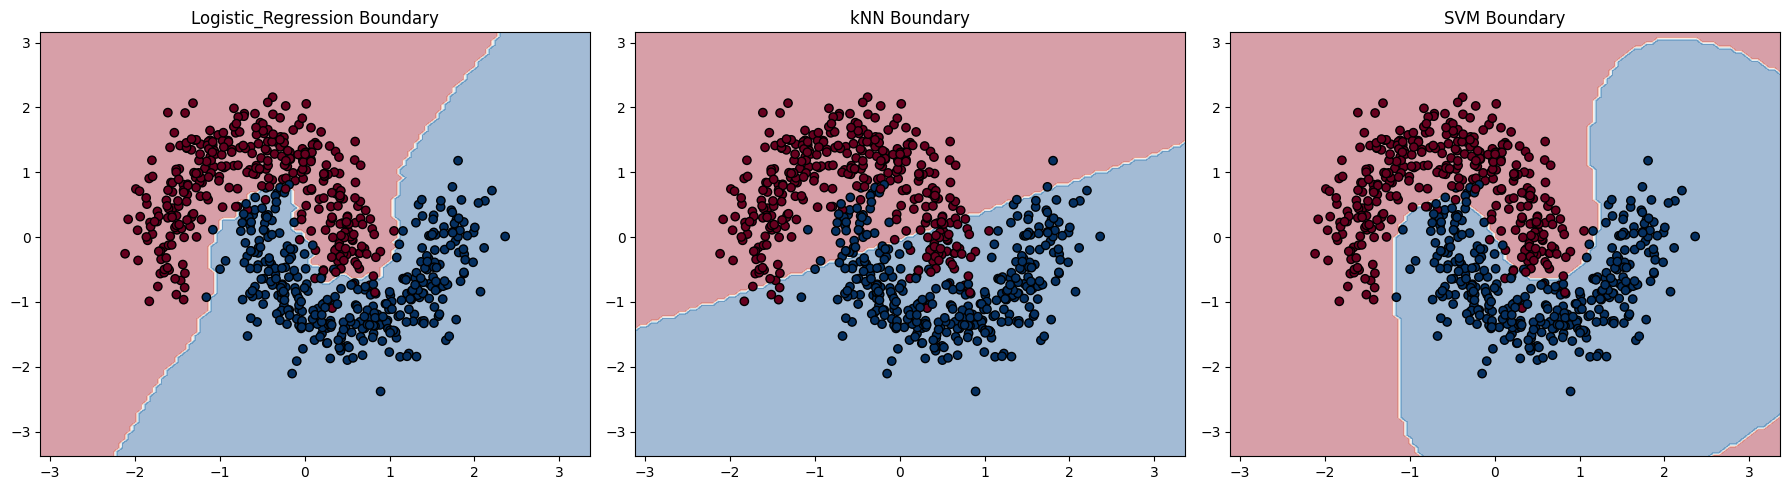


📉 Generating Learning Curves (Bias vs Variance)...


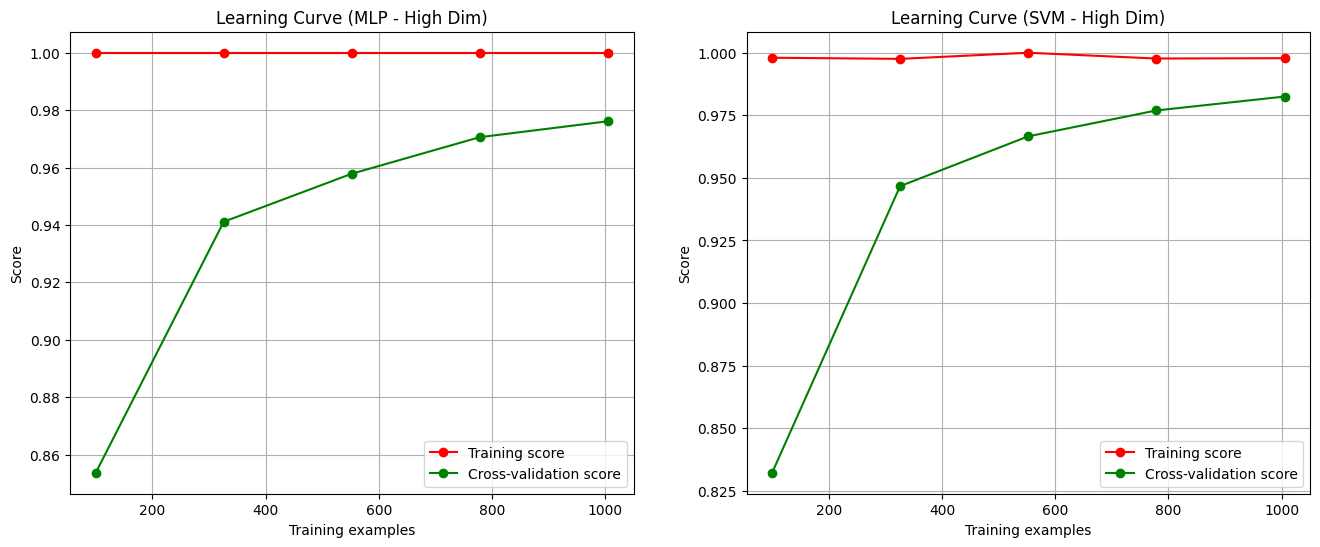

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import learning_curve

# =========================================
# A. VISUALIZE DECISION BOUNDARIES (Moons)
# =========================================
print("📊 Generating Decision Boundaries for Non-Linear Data...")

# We select 3 models to compare: Linear (Fails), kNN (Good), SVM (Best)
selected_models_names = ['Logistic_Regression', 'kNN', 'SVM']
models_to_plot = [row['Estimator'] for row in results_data if row['Dataset'] == 'Non-Linear' and row['Model'] in selected_models_names]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, model in enumerate(models_to_plot):
    # Plot boundary
    DecisionBoundaryDisplay.from_estimator(
        model, X_train_nl, alpha=0.4, ax=axes[i], cmap='RdBu', response_method='predict'
    )
    # Plot data points
    axes[i].scatter(X_train_nl[:, 0], X_train_nl[:, 1], c=y_train_nl, edgecolor='k', cmap='RdBu')
    axes[i].set_title(f"{selected_models_names[i]} Boundary")

plt.tight_layout()
plt.show()

# =========================================
# B. LEARNING CURVES (Bias-Variance Analysis)
# =========================================
print("\n📉 Generating Learning Curves (Bias vs Variance)...")
# We will look at MLP on the High-Dimensional data to check for Overfitting

def plot_learning_curve(estimator, title, X, y, ax):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)
    )
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    ax.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
    ax.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")
    ax.set_title(title)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    ax.legend(loc="best")
    ax.grid()

# Pick MLP from High-Dimensional results
mlp_model = [row['Estimator'] for row in results_data if row['Dataset'] == 'High-Dimensional' and row['Model'] == 'MLP'][0]
svm_model = [row['Estimator'] for row in results_data if row['Dataset'] == 'High-Dimensional' and row['Model'] == 'SVM'][0]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_learning_curve(mlp_model, "Learning Curve (MLP - High Dim)", X_train_high, y_train_high, axes[0])
plot_learning_curve(svm_model, "Learning Curve (SVM - High Dim)", X_train_high, y_train_high, axes[1])

plt.show()
